In [4]:
#spacy english en_core_web_trf

#Librerias a usar

#from bert_serving.client import BertClient
import spacy
#from spacy.pipeline import TextRankFactory
import pytextrank

from collections import Counter
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


from rake_nltk import Rake
#import gensim


#import torch; print(torch.__version__)
import torch
from keybert import KeyBERT


from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer



from copy import deepcopy

/home/alvaromontero/anaconda3/envs/tf_gpu_env/lib/python3.10/site-packages


[nltk_data] Downloading package punkt to
[nltk_data]     /home/alvaromontero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alvaromontero/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/alvaromontero/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alvaromontero/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-05-10 15:56:42.338562: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numeric

In [2]:
#Cargar libros
Book_list=["/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/divine_comedy.txt",'/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Oddysey.txt'
           ,'/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Illiad.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Great_Gatsby.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Tom_Sawyer.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Wuthering_Heights.txt']
#Book_list=[r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\divine_comedy.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Oddysey.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Illiad.txt",
#                r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Great_Gatsby.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Tom_Sawyer.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Wuthering_Heights.txt"]

Books_raw_file=[]
for i in range(len(Book_list)):
    with open(Book_list[i],'r',encoding='utf-8')as f:
        file=f.read()
        Books_raw_file.append(file)
        
        


Exploración de los textos

In [5]:
nlp=spacy.load('en_core_web_trf')
histograms=[]
for i,book in enumerate(Books_raw_file):
    #doc=nlp(book)
    tokens=word_tokenize(book,language='english')
    histograms.append(tokens.copy())
    print(f"Libro {i} {len(tokens)} tokens")

Libro 0 140976 tokens
Libro 1 148139 tokens
Libro 2 240208 tokens
Libro 3 60594 tokens
Libro 4 88749 tokens
Libro 5 145089 tokens


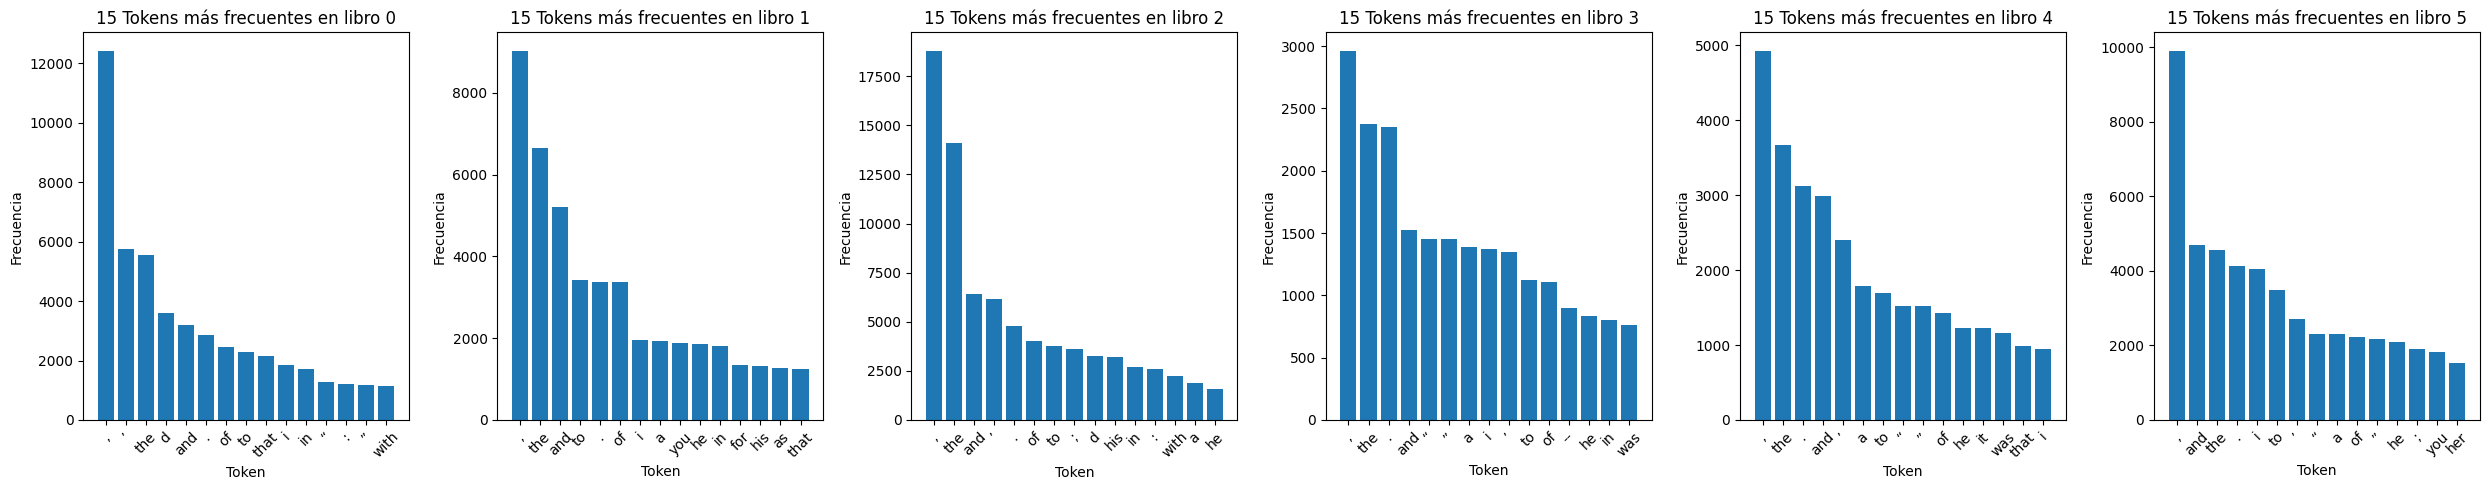

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(histograms), figsize=(25, 5))  # 

for i, histogram in enumerate(histograms):
    tokens_freq = Counter(histogram) #Contador de frecuencia de tokens
    #unique_tokens = [token for token, freq in tokens_freq.items() if freq == 1]
    ordered_tokens = tokens_freq.most_common(15)
    tokens_graph = [token[0] for token in ordered_tokens]
    token_freq = [token[1] for token in ordered_tokens]

    axs[i].bar(tokens_graph, token_freq)
    axs[i].set_title(f'15 Tokens más frecuentes en libro {i}')
    axs[i].set_xlabel('Token')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Ajusta el espaciado entre subplots para que no se superpongan
plt.show()


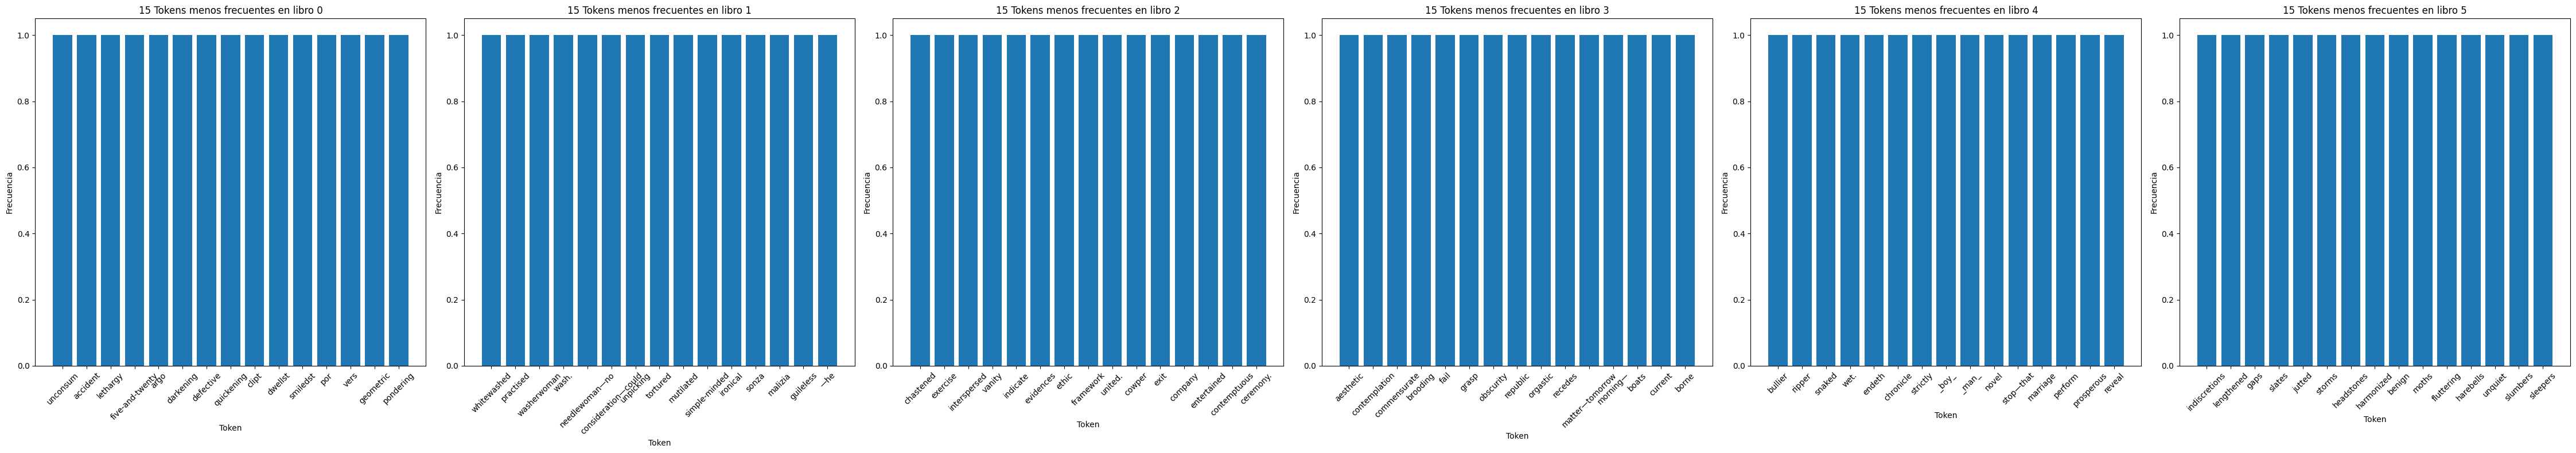

In [39]:
#Tokens menos comunes
fig, axs = plt.subplots(1, len(histograms), figsize=(45, 8)) 
for i, histogram in enumerate(histograms):
    tokens_freq = Counter(histogram) #Contador de frecuencia de tokens
    #unique_tokens = [token for token, freq in tokens_freq.items() if freq == 1]
    ordered_tokens = tokens_freq.most_common()
    ordered_tokens=ordered_tokens[-15:]
    tokens_graph = [token[0] for token in ordered_tokens]
    token_freq = [token[1] for token in ordered_tokens]

    axs[i].bar(tokens_graph, token_freq)
    axs[i].set_title(f'15 Tokens menos frecuentes en libro {i}')
    axs[i].set_xlabel('Token')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Ajusta el espaciado entre subplots para que no se superpongan
plt.show()

PREPROCESAMIENTO


In [6]:
#Funciones
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
def eliminar_etiquetas(text):
    pattern = re.compile(r'<[^>]+>|\([^)]+\)|--[^\-]+--')
    doc = pattern.sub('', text)
    return doc

# Removemos apostrofes para quedarnos con palabras como cant couldnt o dont
def remover_apostrofes(text):
    pattern = r"\\?'"
    doc = re.sub(pattern, '', text)
    return doc
# Nos quedamos con solo alfabeto eliminando caracteres especiales    
def remover_especiales(text):
    pattern = r"[^a-z\s]"
    doc = re.sub(pattern, ' ', text)
    return doc
# Quitamos dobles espacios para tener texto espaciado solamente por un espacio por palabra
def dobles_espacios(text):
    pattern = r'\s+'
    doc = re.sub(pattern, ' ', text)
    return doc
def remove_stopwords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [9]:
#Vectorizacion tfidf
def vectorizar_tfidf(corpus):
    # TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(4,4))
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    # palabras únicas
    feature_names_tfidf = vectorizer.get_feature_names_out()
    vocabulary = vectorizer.get_feature_names_out()
    print("Tamaño de Palabras únicas:", len(feature_names_tfidf))
    return tfidf_matrix,vocabulary

In [7]:
#Quitar inicio de texto
deleted_lines_list=[134,336,1997,32,459,7]

for i,book in enumerate(Books_raw_file):
    lines = book.splitlines()  # Split the book text into lines
    modified_lines = lines[deleted_lines_list[i]:]  # Keep lines starting from the specified index
    modified_book = "\n".join(modified_lines)  # Join the remaining lines back into a string
    Books_raw_file[i]=modified_book
    tokens=word_tokenize(modified_book,language='english')
    #histograms.append(tokens.copy())
    print(f"Libro {i} {len(tokens)} tokens")


Libro 0 140735 tokens
Libro 1 144823 tokens
Libro 2 217152 tokens
Libro 3 60526 tokens
Libro 4 87627 tokens
Libro 5 145084 tokens


In [8]:
for i,book in enumerate(Books_raw_file):
    Books_raw_file[i]=book.lower()
    
print(Books_raw_file[0][:200])

canto i


in the midway of this our mortal life,
i found me in a gloomy wood, astray
gone from the path direct: and e’en to tell
it were no easy task, how savage wild
that forest, how robust and rough


Eliminacion de caracteres no importantes


In [9]:

books_clean_files=[]
books_clean_stops_file=[]
for i,book in enumerate(Books_raw_file):
    Text_aux=eliminar_etiquetas(book)
    Text_aux=remover_apostrofes(Text_aux)
    Text_aux=dobles_espacios(Text_aux)
    books_clean_stops_file.append(deepcopy(Text_aux))#Por si el modelo no necesita quitar stopwords o necesita caracteres especiales
    Text_aux=remover_especiales(Text_aux)
    
    Text_aux=remove_stopwords(Text_aux)
    books_clean_files.append(Text_aux)#Texto sin stopwords
    print(Text_aux[:65]+'\n')

canto midway mortal life found gloomy wood astray gone path direc

book gods council minerva visit ithaca challenge telemachus suito

iliad book argument contention achilles agamemnon war troy greeks

younger vulnerable years father gave advice turning mind ever sin

chapter tom answer tom answer gone boy wonder tom answer old lady

chapter returned visit landlord solitary neighbour shall troubled



Extracción de oraciones clave

1) TF-IDF

In [50]:
#TF-IDF NLTK

for book in books_clean_files:#Iteramos sobre los libros para obtener lo mas representativo de cada texto
    #tokens=word_tokenize(book)
    #postags=pos_tag(tokens)
    #stemmer=PorterStemmer()
    #stemmed_tokens=[stemmer.stem(token) for token in tokens]
    
    
    vectorizer = TfidfVectorizer(ngram_range=(2,4))#Vectorizador con 4 gramas
    tfidf_matrix = vectorizer.fit_transform([book])
    feature_names_tfidf = vectorizer.get_feature_names_out()
    vocabulary = vectorizer.get_feature_names_out()#Obtenemos el bocabulario
    print("Tamaño de Palabras únicas:", len(feature_names_tfidf))
    frecuencia_total = Counter()
    for ngrama in vocabulary:#Contamos las frases mas comunes
    # Obtiene el índice de la palabra en el vocabulario
        indice = vectorizer.vocabulary_[ngrama]
        # Suma las frecuencias de esa palabra en todas las frases
        frecuencia_total[ngrama] = tfidf_matrix[:, indice].sum()
    frases_mas_frecuentes = frecuencia_total.most_common(5)
    for i in range(5):
        print(f"Frase: {frases_mas_frecuentes[i][0]}, Frecuencia: {frases_mas_frecuentes[i][1]}")#El decimal es que tanto contribuyen al "Corpus"




Tamaño de Palabras únicas: 169198
Frase: ne er, Frecuencia: 0.12810990265274277
Frase: mine eyes, Frecuencia: 0.1259385483704929
Frase: thou hast, Frecuencia: 0.10856771411249387
Frase: thou shalt, Frecuencia: 0.08902552557224497
Frase: thou art, Frecuencia: 0.08034010844324546
Tamaño de Palabras únicas: 152100
Frase: let us, Frecuencia: 0.11400327604846489
Frase: one another, Frecuencia: 0.10614098114857075
Frase: every one, Frecuencia: 0.08255409644888836
Frase: ulysses said, Frecuencia: 0.060932785474179504
Frase: eat drink, Frecuencia: 0.05700163802423244
Tamaño de Palabras únicas: 276510
Frase: ph bus, Frecuencia: 0.09993534054456539
Frase: great achilles, Frecuencia: 0.06329238234489142
Frase: great hector, Frecuencia: 0.06329238234489142
Frase: paradise lost, Frecuencia: 0.05996120432673924
Frase: dryden virgil, Frecuencia: 0.04663649225413052
Tamaño de Palabras únicas: 67380
Frase: old sport, Frecuencia: 0.15258290573903543
Frase: new york, Frecuencia: 0.1179049726165274
Frase:

  2.- BERT

In [10]:
#Extracción de frases clave usando BERT
key_model=KeyBERT()
for book in books_clean_stops_file:
    key_phrases=key_model.extract_keywords(book,keyphrase_ngram_range=(3,3),nr_candidates=5)
    print(key_phrases)

[('sorrowing sought thee', 0.5148), ('thee gloom deep', 0.4916), ('wastes sorrows dwell', 0.4848), ('thee bitter seas', 0.4832), ('gone inwardly mourns', 0.4808)]
[('gods settled ithaca', 0.6938), ('gods did ulysses', 0.6804), ('gods people ithaca', 0.669), ('immortal gods ithaca', 0.6539), ('gods mean ulysses', 0.6507)]
[('achilles agamemnon war', 0.6853), ('greeks achilles troops', 0.6848), ('iliad destiny achilles', 0.6693), ('achilles lest greek', 0.6647), ('achilles pursues trojans', 0.6627)]
[('soft mindedness suspecting', 0.5293), ('sleep preoccupation hostile', 0.4955), ('preoccupation hostile levity', 0.4664), ('turbulent emotions possessed', 0.4562), ('curious natures victim', 0.4402)]
[('tom did comfort', 0.5876), ('chapter tom answer', 0.5754), ('did tom _did_', 0.5748), ('tom thought oh', 0.5699), ('mutterings kept tom', 0.5663)]
[('grange said heathcliff', 0.6886), ('grange mr heathcliff', 0.6758), ('heathcliff corroborating surmise', 0.637), ('ascertain mr heathcliff', 0

3.-RAKE

In [9]:
rake_nltk_var = Rake()

for book in books_clean_files:
    rake_nltk_var.extract_keywords_from_text(book)
    keyphrases= rake_nltk_var.get_ranked_phrases()[:5]
    print(keyphrases)

['canto midway mortal life found gloomy wood astray gone path direct e en tell easy task savage wild forest robust rough growth remember dismay renews bitterness far death yet discourse good befell else relate discover first enter scarce say sleepy dullness instant weigh senses true path left mountain foot reach clos valley pierc heart dread look aloft saw shoulders broad already vested planet beam leads wanderers safe every way little respite fear heart recesses deep lain night pitifully pass man difficult short breath forespent toiling scap sea shore turns perilous wide waste stands gaze e en spirit yet fail struggling terror turn view straits none hath pass liv weary frame short pause recomforted journey lonely steep hinder foot still firmer scarce ascent began lo panther nimble light cover speckled skin appear saw vanish rather strove check onward going ofttimes purpose retrace steps turn hour morning prime way aloft sun ascended stars rose love divine first mov fair works joyous h

4.-TextRank

In [24]:


for book in books_clean_stops_file:#Archivos con stopwords
    parser = PlaintextParser.from_string(book,Tokenizer("english"))         
    summarizer = TextRankSummarizer()                   
    summary =summarizer(parser.document,5)      
    print(summary)
    

(<Sentence: n the midway of this our mortal life    found me in a gloomy wood  astray  one from the path direct  and e en to tell  t were no easy task  how savage wild  hat forest  how robust and rough its growth   hich to remember only  my dismay  enews  in bitterness not far from death   et to discourse of what there good befell   ll else will   relate discover d there   ow first   enter d it   scarce can say   uch sleepy dullness in that instant weigh d  y senses down  when the true path   left   ut when a mountain s foot   reach d  where clos d  he valley  that had pierc d my heart with dread    look d aloft  and saw his shoulders broad  lready vested with that planet s beam   ho leads all wanderers safe through every way   hen was a little respite to the fear   hat in my heart s recesses deep had lain   ll of that night  so pitifully pass d   nd as a man  with difficult short breath   orespent with toiling   scap d from sea to shore   urns to the perilous wide waste  and stands  t

Resumen Automático de Texto

In [11]:
from copy import deepcopy
paths=['/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/moby_chapter.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/frankenstein.txt']
chapters=[]
for i in range(len(paths)):
    with open(paths[i],'r',encoding='utf-8')as f:
     file=f.read()
     print(file[:45])
     chapters.append(deepcopy(file))

Call me Ishmael. Some years ago—never mind ho
I am by birth a Genevese; and my family is on


In [18]:
chapters_clean=[]
chapter_stops_clean=[]
for chapter in chapters:
    Text_aux=eliminar_etiquetas(chapter)
    Text_aux=remover_apostrofes(Text_aux)
    Text_aux=dobles_espacios(Text_aux)
    Text_aux=remover_especiales(Text_aux)
    chapter_stops_clean.append(deepcopy(Text_aux))#Capitulos con stopwords
    output=remove_stopwords(Text_aux)
    chapters_clean.append(deepcopy(output))

1.-Frecuencia de palabras normalizada

In [11]:
nlp=spacy.load('en_core_web_trf')

for chapter in chapters_clean:
    doc=nlp(chapter)
    puntuaciones = []
    frecuencias = {}
    for token in doc:
        if token.is_alpha and not token.is_stop:
            palabra_normalizada = token.lemma_
            frecuencias[palabra_normalizada] = frecuencias.get(palabra_normalizada, 0) + 1
    frecuencia_maxima = max(frecuencias.values())
    puntuaciones = []
    for oracion in doc.sents:
        oracion_frecuencias = [frecuencias.get(token.lemma_, 0) / frecuencia_maxima for token in oracion if token.is_alpha and not token.is_stop]
        if oracion_frecuencias:
            puntuacion = sum(oracion_frecuencias) / len(oracion_frecuencias)
            puntuaciones.append((oracion, puntuacion))
    oraciones_ordenadas = sorted(puntuaciones, key=lambda x: x[1], reverse=True)
    for i, (oracion, puntuacion) in enumerate(oraciones_ordenadas[:10]):
        print(f"{i+1}. {oracion} (Puntuación: {puntuacion})")

1. man (Puntuación: 0.5)
2. stand (Puntuación: 0.35714285714285715)
3. man receives money really marvellous considering earnestly believe money root earthly ills account monied man enter heaven h cheerfully consign perdition inally always go sea sailor (Puntuación: 0.18944099378881993)
4. legs set feet going infallibly lead water water region hould ever athirst great merican desert try experiment caravan happen supplied metaphysical professor es every one knows meditation water wedded ever ut artist e desires paint dreamiest shadiest quietest enchanting bit romantic landscape valley aco hat chief element employs stand trees hollow trunk hermit crucifix within sleeps meadow sleep cattle yonder cottage goes sleepy smoke eep distant woodlands winds mazy way reaching overlapping spurs mountains bathed hill side blue ut though picture lies thus tranced though pine tree shakes sighs like leaves upon shepherds head yet vain unless shepherds eye fixed upon magic stream visit rairies une scores

2.-Gensim

In [33]:
from gensim.summarization.summarizer import summarize#No funciona sin caraceteres especiales
for i,chapter in enumerate(chapters_clean):
    resumen=summarize(chapter)
    print(i)
    print(resumen)

0
Whenever I find growing grim mouth ; whenever damp , drizzly November soul ; whenever I find involuntarily pausing coffin warehouses , bringing rear every funeral I meet ; especially whenever hypos get upper hand , requires strong moral principle prevent deliberately stepping street , methodically knocking peoples hats off—then , I account high time get sea soon I .
—Posted like silent sentinels around town , stand thousands upon thousands mortal men fixed ocean reveries .
Let absent-minded men plunged deepest reveries—stand man legs , set feet a-going , infallibly lead water , water region .
But though picture lies thus tranced , though pine-tree shakes sighs like leaves upon shepherds head , yet vain , unless shepherds eye fixed upon magic stream .
Why almost every robust healthy boy robust healthy soul , time crazy go sea ?
Why upon first voyage passenger , feel mystical vibration , first told ship sight land ?
Now , I say I habit going sea whenever I begin grow hazy eyes , begin 

3.-TextRank


In [19]:
for chapter in chapter_stops_clean:
    parser = PlaintextParser.from_string(chapter,Tokenizer("english"))         
    summarizer = TextRankSummarizer()                   
    summary =summarizer(parser.document,10)      
    print(summary)

(<Sentence: all me  shmael   ome years ago never mind how long precisely  having little or no money in my purse  and nothing particular to interest me on shore    thought   would sail about a little and see the watery part of the world   t is a way   have of driving off the spleen and regulating the circulation   henever   find myself growing grim about the mouth  whenever it is a damp  drizzly  ovember in my soul  whenever   find myself involuntarily pausing before coffin warehouses  and bringing up the rear of every funeral   meet  and especially whenever my hypos get such an upper hand of me  that it requires a strong moral principle to prevent me from deliberately stepping into the street  and methodically knocking peoples hats off then    account it high time to get to sea as soon as   can   his is my substitute for pistol and ball   ith a philosophical flourish  ato throws himself upon his sword    quietly take to the ship   here is nothing surprising in this   f they but knew it

4.-LSA

In [29]:
for chapter in chapter_stops_clean:
    parser= PlaintextParser.from_string(chapter,Tokenizer("english"))
    summarizer_lsa = LsaSummarizer()
    resumen=summarizer_lsa(parser.document,10)
    print(resumen)

(<Sentence: all me  shmael   ome years ago never mind how long precisely  having little or no money in my purse  and nothing particular to interest me on shore    thought   would sail about a little and see the watery part of the world   t is a way   have of driving off the spleen and regulating the circulation   henever   find myself growing grim about the mouth  whenever it is a damp  drizzly  ovember in my soul  whenever   find myself involuntarily pausing before coffin warehouses  and bringing up the rear of every funeral   meet  and especially whenever my hypos get such an upper hand of me  that it requires a strong moral principle to prevent me from deliberately stepping into the street  and methodically knocking peoples hats off then    account it high time to get to sea as soon as   can   his is my substitute for pistol and ball   ith a philosophical flourish  ato throws himself upon his sword    quietly take to the ship   here is nothing surprising in this   f they but knew it